## Data cleaning & EDA

In [1]:
import re
import pandas as pd

In [ ]:
df_benign = pd.read_csv('../Data/CSV_benign.csv')
df_malware = pd.read_csv('../Data/CSV_malware.csv')

# 'Country' column name is duplicated in malware csv, therefore I decided to rename both. While reading it, pandas reads duplicated column name with '.1' suffix
df_benign.rename(columns={'Country.1':'Country_1'}, inplace=True)
df_malware.rename(columns={'Country.1':'Country_1'}, inplace=True)

# Reindex columns
df_benign = df_benign.reindex(sorted(df_benign.columns), axis=1)
df_malware = df_malware.reindex(sorted(df_malware.columns), axis=1)
# df_malware.head(3)

In [3]:
# A few basic data checks
print('Shape of benign df: ', df_benign.shape, ' | Shape of malware df: ', df_malware.shape)
print(f'The dataset contains a high imbalance: among {df_benign.shape[0]+df_malware.shape[0]} total samples (w/o dropping duplicates)')
print(f'only {df_malware.shape[0]} samples are marked as threat, which is {(df_malware.shape[0]/(df_benign.shape[0]+df_malware.shape[0]))*100:.3f}%  (w/o dropping duplicates)')
print(f'# of columns in df_benign: {df_benign.columns.value_counts().sum()} | # of columns in df_malware: {df_malware.columns.value_counts().sum()}')
print(f'Does two dataframes column names match? {df_benign.columns.tolist().sort() == df_malware.columns.tolist().sort()}')
print(f'Dtypes match check: \n{df_benign.dtypes == df_malware.dtypes}')

Shape of benign df:  (494135, 38)  | Shape of malware df:  (4999, 38)
The dataset contains a high imbalance: among 499134 total samples (w/o dropping duplicates)
only 4999 samples are marked as threat, which is 1.002%  (w/o dropping duplicates)
# of columns in df_benign: 38 | # of columns in df_malware: 38
Does two dataframes column names match? True
Dtypes match check: 
1gram                  True
2gram                  True
3gram                  True
ASN                    True
Alexa_Rank            False
Country                True
Country_1              True
Creation_Date_Time     True
Domain                 True
Domain_Age             True
Domain_Name            True
Emails                 True
IP                     True
Name_Server_Count     False
Organization           True
Page_Rank              True
Registrant_Name        True
Registrar              True
State                  True
TTL                   False
char_distribution      True
dec_32                False
dec_8     

In [4]:
# By digging into missmatch in dtypes, I was able to identify 'mixing' of columns data in 24 records of df_malware.
# To fix it, following steps are taken: 1. Identify incorrect rows by checking len of IP column,
#   2. Get records into new df
#   3. Rename columns
#   4. Drop incorrect rows from df_malware
#   5. Concatenate fixed data to df_malware

incorrect_rows_idx = df_malware.index[df_malware['IP'].str.len()==2]
df_incorrect_rows = df_malware.iloc[incorrect_rows_idx]

# Applies to df_malware only - rename of columns for 24 records
col_val_replace_to = {
    'Country': 'TTL',
    'TTL': 'Domain',
    'IP': 'Country',
    'Domain': 'IP',
}

df_incorrect_rows.rename(columns=col_val_replace_to, inplace=True) # Apply rename
df_malware.drop(incorrect_rows_idx, axis=0, inplace=True) # Drop from malware df incorrect rows
df_malware = pd.concat([df_malware, df_incorrect_rows], ignore_index=False) # Concatenate fixed data

C:\Users\rafal\AppData\Local\Temp\ipykernel_19160\2132842539.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incorrect_rows.rename(columns=col_val_replace_to, inplace=True) # Apply rename


In [5]:
df_benign.index[df_benign['IP'].str.len()==2] # Proof: this case does not affect benign df

Index([], dtype='int64')

In [6]:
# Drop from malware df 2 records with domain equal to 397220 (incorrectly imputed data)
df_malware.drop(df_malware.index[df_malware['Domain']=='397220'], axis=0, inplace=True)

In [7]:
# Just to make sure, domains in benign df are also checked (by looking at csv) - after checking it domains look fine
unique_domains_benign = df_benign['Domain'].unique()
# pd.DataFrame(unique_domains_benign).to_csv('./tmp/unique_domains_benign.csv')

In [8]:
# Dataset contains a lot of null/nan in columns like e.g. Country, ASN, IP, Domain_Name, State and so on.
# It is a common knowledge that ASN and IP might change (e.g. by a load balancer), however acording to
# Mahdavifar et al. (2021) the data has been gathered in a sliding window τ, which was relatively short (approx. 0,7s for b'instagram.com.' domain in benign df).
# Therefore, I made an assumption that only [Domain_Age] might be different across samples of the same domain.
# In the code below I used forward and backward filling of missing values for certain domain, 
#   followed by work on nulls and drop of duplicates.
# Primary task is to classify malicious domains, therefore drop of redundant data is reasonable (note that it might be distincted by [Domain_Age]).

def custom_filling(df):
    if not df['Domain'].isnull().sum().sum() == 0:
        raise Exception("Exception: The dataset contains null values in Domain column! Please provide correct dataset or change filling approach.")
    
    print('Df shape before the filling process & dropping duplicates: ', df.shape)
    # df = df.groupby(['Domain']).apply(lambda group: group.ffill()) # TODO/Done: Improve performance + bfill

    df['Domain_tmp'] = df['Domain'] # The reason to do it this way is that as_index is ignored in groupby op, and it is anyway faster than apply approach
    df = df.groupby(['Domain_tmp'], as_index=False).ffill()

    df['Domain_tmp'] = df['Domain'] # The reason to do it this way is that as_index is ignored in groupby op, and it is anyway faster than apply approach
    df = df.groupby(['Domain_tmp'], as_index=False).bfill()
    df.drop(columns=['Domain_Age'], inplace=True)
    df.drop_duplicates(inplace=True)
    print('After filling & drop of duplicates: ', df.shape)
    print('Checking for nulls not filled: \n', df.isnull().sum(axis = 0))
    return df

df_malware = custom_filling(df_malware)
df_benign = custom_filling(df_benign)

Df shape before the filling process & dropping duplicates:  (4997, 38)
After filling & drop of duplicates:  (4205, 37)
Checking for nulls not filled: 
 1gram                    0
2gram                    0
3gram                    0
ASN                     55
Alexa_Rank             457
Country                 57
Country_1             1780
Creation_Date_Time     950
Domain                   0
Domain_Name            823
Emails                1342
IP                       9
Name_Server_Count      457
Organization          2310
Page_Rank              457
Registrant_Name       4139
Registrar             1066
State                 2010
TTL                      0
char_distribution        0
dec_32                   0
dec_8                    0
entropy                  0
hex_32                   0
hex_8                    0
len                      0
longest_word             0
numeric_percentage       0
obfuscate_at_sign        0
oc_32                    0
oc_8                     0
puny_coded 

In [9]:
# To mitigate missing values across similar columns like Domain, Domain_Name and Country, Country_1, following code is applied to df's
# The code also applies mapping to unify a bit entries
countries_map = {
    '-':'',
    "china":"CN",
    "Malaysia":'ID',
    "United States":"US",
    "TURKEY":'TR',
    'RUSSIA':'RU',
    'Russian Federation':'RU',
    'Belarus':'BY',
    'Korea':'KR',
}

def use_regex(input_text):
    return re.sub(r"b'(.+?).'", r"\1", input_text)

def impute_similar_cols(df):
    df["Country_1"].replace(countries_map, inplace=True)
    df["Country"].replace(countries_map, inplace=True)
    df["Country_1"].fillna(df["Country"], inplace=True)
    df["Country"].fillna(df["Country_1"], inplace=True)
    df["Domain_Name"].fillna(df["Domain"].apply(use_regex), inplace=True)
    return df

df_malware = impute_similar_cols(df_malware)
df_benign = impute_similar_cols(df_benign)

In [10]:
print(f'Dtypes match check: \n{df_benign.dtypes == df_malware.dtypes}')

Dtypes match check: 
1gram                  True
2gram                  True
3gram                  True
ASN                    True
Alexa_Rank            False
Country                True
Country_1              True
Creation_Date_Time     True
Domain                 True
Domain_Name            True
Emails                 True
IP                     True
Name_Server_Count     False
Organization           True
Page_Rank              True
Registrant_Name        True
Registrar              True
State                  True
TTL                   False
char_distribution      True
dec_32                False
dec_8                 False
entropy               False
hex_32                False
hex_8                 False
len                   False
longest_word           True
numeric_percentage    False
obfuscate_at_sign     False
oc_32                 False
oc_8                  False
puny_coded            False
shortened             False
sld                    True
subdomain             False

In [11]:
df_benign['entropy'].unique()

array(['1.8348756474779464', '2.1142465351822795', '2.5954888901709436',
       ..., 3.205847659664522, 3.343129822946646, 1.375], dtype=object)

In [12]:
df_benign['len'].unique()

array(['7', '10', '9', '12', '8', '11', '13', '6', '15', '4', '17', '22',
       '3', '14', '2', '16', '5', '18', '19', '1', '24', '20', '21', '25',
       '23', '6Admin', '9Admin', '11Admin', '14Admin', '26', '28',
       'euskadi', '30', '33', '29', '27', '31', nan, ' LLC',
       ' LLC (PrivacyProtect.org)', ' Inc', ' LIMITED', ' Ltd.',
       ' Los Angeles', 'user', 'devil', '32',
       ' this company does not own this domain name s.r.o.', ' inc',
       ' London Limited', 's LLC', ' JSC.',
       "['Charities Aid Foundation', 'REDACTED FOR PRIVACY']", 'Ltd.',
       ' LLC.', '16Admin', ' Ltd', 'net', ' dba Middle-earth Enterprises',
       '40', ' Ltda.', ' LTD.',
       ' AGENCE FRANCAISE DE DEVELOPPEMENT TOURISTIQUE', ' Houston',
       'Myanmar Consolidated Media Ltd.', ' JSC', ' s.r.o.',
       ' LLC - On Behalf of Domain Owner', ' LP', 'ltd', 'Inc.', '8Admin',
       ' Advertising', ' UT-Austin', ' Harvard', ' a Nielsen Company',
       ' LLC - On Behalf of Domain Buyer', ' 

In [13]:
df_benign.dtypes

1gram                  object
2gram                  object
3gram                  object
ASN                   float64
Alexa_Rank             object
Country                object
Country_1              object
Creation_Date_Time     object
Domain                 object
Domain_Name            object
Emails                 object
IP                     object
Name_Server_Count      object
Organization           object
Page_Rank             float64
Registrant_Name        object
Registrar              object
State                  object
TTL                     int64
char_distribution      object
dec_32                 object
dec_8                  object
entropy                object
hex_32                 object
hex_8                  object
len                    object
longest_word           object
numeric_percentage     object
obfuscate_at_sign      object
oc_32                  object
oc_8                   object
puny_coded             object
shortened              object
sld       

In [14]:
df_benign['shortened'].isnull().sum()

1033

In [15]:
# Not all columns with missmatch data type are being processed in this function
def process_cols_to_type(df):
    df['Alexa_Rank'] = pd.to_numeric(df["Alexa_Rank"], errors='coerce') # Should be number
    df['Alexa_Rank'].fillna(0, inplace=True)
    df['Name_Server_Count'] = pd.to_numeric(df["Name_Server_Count"], errors='coerce') # Should be number
    df['TTL'] = pd.to_numeric(df["TTL"], errors='coerce') # Should be number
    df['entropy'] = pd.to_numeric(df["entropy"], errors='coerce') # Should be number
    df['len'] = pd.to_numeric(df["len"], errors='coerce') # Should be number - Length of domain and subdomain
    df['len'].fillna(len(df['Domain_Name']), inplace=True)
    df['numeric_percentage'] = pd.to_numeric(df["numeric_percentage"], errors='coerce') # Should be number - Counts the number of digits in domain and subdomain
    return df


df_malware = process_cols_to_type(df_malware)
df_benign = process_cols_to_type(df_benign)

In [16]:
# # Store data to csv for manual analysis
# df_benign.to_csv('./tmp/df_benign_filled.csv')
# df_malware.to_csv('./tmp/df_malware_filled.csv')

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

label_encoder = LabelEncoder()
scaler = MinMaxScaler()

def encode_cols(df):
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].astype(str)
            df[col] = label_encoder.fit_transform(df[col])    
    return df

# Also filling na's with 0s instead of dropping those records for a test
def scale_df(df):
    return pd.DataFrame(scaler.fit_transform(df.fillna(0)), columns=df.columns)

df_benign = encode_cols(df_benign)
df_malware = encode_cols(df_malware)
df_benign = scale_df(df_benign)
df_malware = scale_df(df_malware)

In [20]:
# Add labels/flag to indicate if a domain sample is a threat or not
df_benign['is_threat'] = 0
df_malware['is_threat'] = 1

# Combine two dataframes
df = pd.concat([df_benign, df_malware])
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(3)

,1gram,2gram,3gram,ASN,Alexa_Rank,Country,Country_1,Creation_Date_Time,Domain,Domain_Name,...,obfuscate_at_sign,oc_32,oc_8,puny_coded,shortened,sld,subdomain,tld,typos,is_threat
0,0.363337,0.3333,0.362721,0.03809,1.831711e-07,0.929766,0.294464,0.018479,0.275212,0.442257,...,0.000074,0.000278,0.0,0.0,0.0,0.364296,0.005464,0.974067,0.344735,0
1,0.363337,0.3333,0.362721,0.03809,1.831711e-07,0.929766,0.294464,0.018479,0.275212,0.442257,...,0.000074,0.000278,0.0,0.0,0.0,0.364296,0.005464,0.974067,0.344735,0
2,0.363337,0.3333,0.362721,0.03809,1.831711e-07,0.929766,0.294464,0.018479,0.821619,0.125049,...,0.000074,0.000278,0.0,0.0,0.0,0.364296,0.306011,0.974067,0.344735,0


In [22]:
X = df.drop(columns='is_threat')
y = df['is_threat']

In [23]:
from imblearn.combine import SMOTETomek

def balance_data(X_part, y_part):
    X_bal, y_bal = SMOTETomek(sampling_strategy='auto').fit_resample(X_part, y_part)
    return X_bal, y_bal

# X, y = balance_data(X, y)

## Feature Selection

In [29]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import numpy as np

clf = SelectKBest(mutual_info_classif)
clf = clf.fit(X, y)

feature_importance = clf.scores_
p_values = clf.pvalues_

if p_values is None:
    p_values = np.empty(len(feature_importance))
    p_values[:] = np.nan
top_sortindex = np.argsort(feature_importance)[::-1]

max_features = X.columns.value_counts().sum()
top_features = X.columns[top_sortindex][:max_features][::-1].tolist()
top_features_importance = feature_importance[top_sortindex][:max_features][::-1]
top_features_pvalues = p_values[top_sortindex][:max_features][::-1]

sorted_features = sorted(list(zip(top_features, top_features_importance)), key=lambda x: x[1], reverse=True)
sorted_features[:15]

[('Registrant_Name', 0.1462331865548837),
 ('Country', 0.09204986988402608),
 ('State', 0.08658711451756695),
 ('Organization', 0.0805877166586868),
 ('subdomain', 0.08033031370570431),
 ('tld', 0.07800277248557641),
 ('dec_32', 0.07640785568435426),
 ('Country_1', 0.07324608605707728),
 ('Registrar', 0.06797784822107045),
 ('TTL', 0.063754039756727),
 ('len', 0.06320493798034621),
 ('Emails', 0.06089021270933237),
 ('oc_32', 0.06012337075657126),
 ('typos', 0.05555507271215587),
 ('entropy', 0.055425472441483215)]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

min_features_to_select = 1  # Minimum number of features to consider
# estimator = GradientBoostingClassifier(random_state=42)
# estimator = RandomForestClassifier(random_state=42)
estimator = LogisticRegression(random_state=42, max_iter=3000)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=sss,
    scoring="balanced_accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv = rfecv.fit(X, y)
print(f"Optimal number of features: {rfecv.n_features_}")

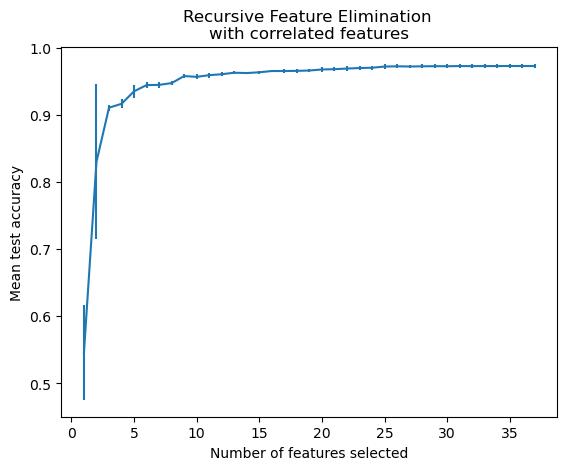

In [26]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## References

Samaneh Mahdavifar, Nasim Maleki, Arash Habibi Lashkari, Matt Broda, Amir H. Razavi, “Classifying Malicious Domains using DNS Traffic Analysis”, The 19th IEEE International Conference on Dependable, Autonomic, and Secure Computing (DASC), Oct. 25-28, 2021, Calgary, Canada